# Alex Herrerías Ramírez

## Ejercicio 1
Durante el ejercicio se explicaran la toma de decisiones para cada paso antes de ejecutar el codigo y se comentaran las salidas con imagenes de los resultados en el entorno HDFS

Lo primero es crear la carpeta donde guardar los archivos que creemos fuera del entorno hadoop

In [1]:
# En el caso de que se ejecute varias veces el codigo, asegurarse estar en la carpeta de inicio
import os
os.chdir("/media/notebooks")
!pwd

/media/notebooks


In [2]:
import os
! mkdir -p ejercicio-1
os.chdir("ejercicio-1")
! pwd

/media/notebooks/ejercicio-1


Asegurarse de que los archivos clients.csv y countries.csv este en /notebooks/ejercicio-1/, como no indica el enunciado una ruta en concreto a seguir, se asume que se mueven a mano.

### Ejercicio 1.1 - creación del mapper

- Lo que queremos conseguir con el mapper es filtrar los clientes "buenos" y enviar el resultado con el formato (NombrePais, 1) al reducer
- Si la columna de valoración es "bueno" se enviara el NombrePais al reducer junto un contador
- Usare un Mapper-side Join ya que el archivo "countries.csv" es relativamente pequeño cargando el archivo en la memoria del mapper usando un diccionario Python al inicio y hadoop distribuirá el contenido a todos los nodos
- Se enviara una Clave/Valor al reducer con el siguiente formato:
    - Clave: Nombre del País
    - Valor: 1 (basicamente usaremos un contador)
    - Se usara como separador un tabulador (\t)

In [3]:
%%writefile mapper.py
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""mapper.py - Ejercicio 1.1"""

import sys

# Esta función se encarga de cargar el archivo countries.csv en un diccionario como hemos comentado anteriormente
def cargar_diccionario_paises():
    dic_paises = {}
    try:
        with open("countries.csv", mode='r', encoding='utf-8') as archivo:
            for i, linea in enumerate(archivo):
                # Omitimos la cabecera
                if i == 0:
                    continue

                linea = linea.strip()
                if not linea:
                    continue

                partes = linea.split(',')
                if len(partes) >= 2:
                    # Clave = Code, Valor = Name
                    nombre = partes[0].strip().strip('"')
                    codigo = partes[1].strip().strip('"')
                    dic_paises[codigo] = nombre
                    
    except FileNotFoundError:
        sys.stderr.write("Error: No se pudo encontrar el archivo.")  

    return dic_paises

def main():
    buscador_paises = cargar_diccionario_paises()
    
    if not buscador_paises:
        sys.stderr.write("Error al cargar el diccionario")
        return

    # Para cada linea la separamos en partes y obtenemos el codigo y su rating, si es bueno el mapper emitira el valor
    for linea in sys.stdin:
        try:
            linea = linea.strip()
            if not linea:
                continue

            partes = linea.split(',')
            
            if len(partes) < 3:
                continue

            rating = partes[1].strip()
            codigo = partes[2].strip()

            # Filtramos los clientes
            if rating == "bueno":
                nombre_pais = buscador_paises.get(codigo, "País Desconocido")
                # Emitimos el par a la salida
                print(f"{nombre_pais}\t1")
        
        # En el caso de que haya alguna linea mal formada continuamos
        except Exception as e:
            sys.stderr.write(f"Error procesando línea '{linea}': {e}\n")

if __name__ == "__main__":
    main()


Overwriting mapper.py


### Ejercicio 1.1 - creación del reducer

- En el reducer se busca sumar el contador que el mapper le pasa para cada País en el formato (NombrePaís, 1)
- Hadoop se encarga de que la entrada al reducer llega con el formato que queremos, iteraremos linea por linea y usaremos un contador para el pais que se este procesando
- Cuando se cambia de pais se emite el resultado acumulado del país anterior con el formato (País, TotalContador), separado por un tabulador como anteriormente y se vuelven a resetear los contadores.
- Una vez que se termine la tarea se emite el ultimo resultado.

In [4]:
%%writefile reducer.py
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""reducer.py - Ejercicio 1.1"""

import sys

pais_actual = None
conteo_actual = 0

# Linea a linea obtenemos cada pais y acumulamos los resultados y se emiten posteriormente
for linea in sys.stdin:
    try:
        linea = linea.strip()
        pais, conteo_str = linea.split('\t', 1)
        conteo = int(conteo_str)
        
        if pais_actual == pais:
            conteo_actual += conteo
        else:
            if pais_actual:
                print(f"{pais_actual}\t{conteo_actual}")
            
            pais_actual = pais
            conteo_actual = conteo
    except ValueError:
        continue
    # En el caso de que haya alguna linea mal formada continuamos
    except Exception as e:
        sys.stderr.write(f"Error procesando línea '{linea}': {e}\n")

# No he conseguido que se envie el ultimo país procesado dentro del for, por lo que es necesario procesar el ultimo país manualmente
if pais_actual:
    print(f"{pais_actual}\t{conteo_actual}")

Overwriting reducer.py


### Ejercicio 1.1 Ejecutar el MapReduce en HDFS

He tenido errores al ejecutar el HDFS debido a los permisos en los archivos, por eso es mejor asegurarnos que tenemos los permisos correspondientes

In [5]:
!chmod +x mapper.py
!chmod +x reducer.py

Crearemos el directorio en HDFS y subiremos el archivo de datos al sistema, por si se ha ejecutado el codigo anteriormente, borramos la salida previa si existe

In [6]:
!hdfs dfs -mkdir -p /user/ejercicio-1
!hdfs dfs -put -f clients.csv /user/ejercicio-1/
!hdfs dfs -rm -r /user/ejercicio-1/output_ej1_1

Deleted /user/ejercicio-1/output_ej1_1


Por ultimo nos queda ejecutar el Mapreduce (recuerdo que el archivo clients.csv y countries.csv debe estar dentro de la carpeta ejercicio-1) y observar el resultado

In [7]:
!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-*.jar \
-D mapred.job.name="Ejercicio 1.1" \
-files mapper.py,reducer.py,countries.csv \
-mapper "python3 mapper.py" \
-reducer "python3 reducer.py" \
-input /user/ejercicio-1/clients.csv \
-output /user/ejercicio-1/output_ej1_1

packageJobJar: [/tmp/hadoop-unjar7342602312561287014/] [] /tmp/streamjob4277029252566172723.jar tmpDir=null
2025-11-19 11:11:51,422 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at yarnmanager/172.18.0.3:8032
2025-11-19 11:11:51,497 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at yarnmanager/172.18.0.3:8032
2025-11-19 11:11:51,629 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1763547192244_0007
2025-11-19 11:11:52,000 INFO mapred.FileInputFormat: Total input files to process : 1
2025-11-19 11:11:52,058 INFO mapreduce.JobSubmitter: number of splits:2
2025-11-19 11:11:52,076 INFO Configuration.deprecation: mapred.job.name is deprecated. Instead, use mapreduce.job.name
2025-11-19 11:11:52,140 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1763547192244_0007
2025-11-19 11:11:52,140 INFO mapreduce.JobSubmitter: Executing with tokens: []
2025-11-19

Vamos a visualizar el archivo de salida para ver los resultados

In [8]:
!hdfs dfs -cat /user/ejercicio-1/output_ej1_1/part-00000

Canada	1
Guam	3
Guinea	1
Portugal	1
Qatar	1
Somalia	1
South Africa	1
South Georgia and the South Sandwich Islands	1
South Sudan	1
Spain	3
Turkey	1
United States	1


Podemos observar que se ha ejecutado correctamente el MapReduce y en la imagen que han hecho falta 2 Mappers y 1 Reduce

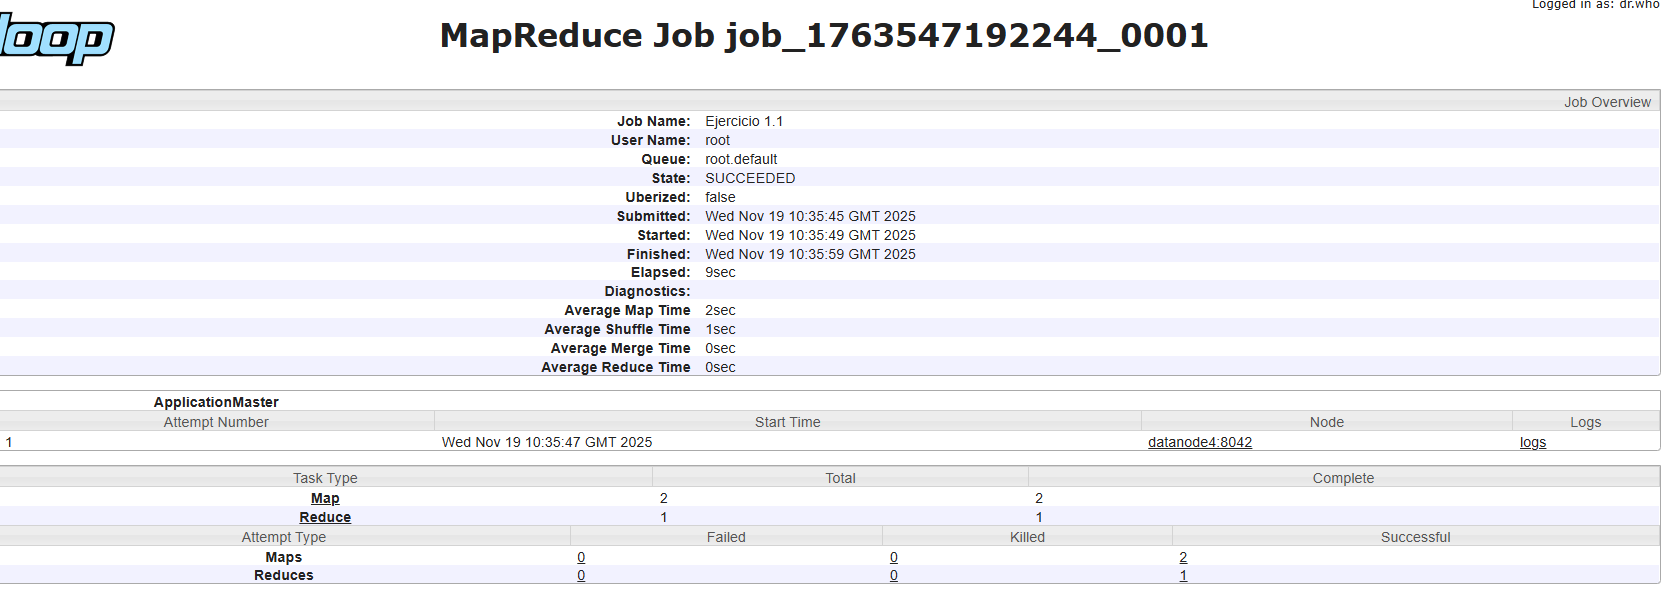

## Ejercicio 1.2
Como en el ejercicio 1.1, nos aseguraremos de estar en la carpeta correcta y trabajaremos a partir de ahi

In [9]:
# En el caso de que se ejecute varias veces el codigo, asegurarse estar en la carpeta de inicio
import os
os.chdir("/media/notebooks")
!pwd

/media/notebooks


In [10]:
import os
!mkdir -p ejercicio-1.2
os.chdir("ejercicio-1.2")
!pwd

/media/notebooks/ejercicio-1.2


### Ejercicio 1.2 - creación del mapper

- En este caso, trabajaremos con la entrada obtenida del anterior MapReduce, el objetivo es preparar los datos para que luego en el reducer podamos obtener el máximo global
- Leeremos la entrada que tendra un formato "Spain\t3", le incluiremos una clave estática y asi nos aseguraremos de que se envien todas al mismo Reducer para tener un resultado único.

In [11]:
%%writefile mapper-ej1.2.py
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""mapper.py - Ejercicio 1.2"""

import sys

for linea in sys.stdin:
    try:
        linea = linea.strip()
        if not linea:
            continue
        print(f"1\t{linea}")
        
    # En el caso de que haya alguna linea mal formada continuamos
    except Exception as e:
        sys.stderr.write(f"Error procesando línea '{linea}': {e}\n")

Overwriting mapper-ej1.2.py


### Ejercicio 1.2 - creación del reducer

- En el reducer buscamos el valor máximo del total de países de forma individual
- Para esto, el reducer una vez que obtenga todas las lineas (nos hemos asegurado que vayan al mismo reducer), itere cada una de ellas y por cada país diferente sume su total y guarde solamente
el país con el máximo valor
- Una vez que se han iterado sobre todas las lineas se enviara el país con el máximo conteo (si hay varios con el mismo numero, se enviara solamente uno)

In [12]:
%%writefile reducer-ej1.2.py
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""reducer.py - Ejercicio 1.2"""
import sys

conteo_max_actual = 0
pais_max = None

# Procesamos línea por línea la entrada
for linea in sys.stdin:
    try:
        clave, valor = linea.strip().split('\t', 1)
        pais, conteo_str = valor.split('\t', 1)
        conteo = int(conteo_str)
        
        if conteo > conteo_max_actual:
            conteo_max_actual = conteo
            pais_max = pais

    # En el caso de que haya alguna linea mal formada continuamos
    except Exception as e:
        sys.stderr.write(f"Error procesando línea '{linea}': {e}\n")

# Solo devolvemos un pais, incluso si hay empate
if pais_max is not None:
    print(f"{pais_max}\t{conteo_max_actual}")

Overwriting reducer-ej1.2.py


### Ejercicio 1.2 Ejecutar el MapReduce en HDFS

Al igual que en el ejercicio 1.1, nos aseguramos de tener los permisos correctos

In [13]:
!chmod +x mapper-ej1.2.py
!chmod +x reducer-ej1.2.py

Borramos la salida previa si existe

In [14]:
!hdfs dfs -rm -r /user/ejercicio-1/output_ej1_2

Deleted /user/ejercicio-1/output_ej1_2


Ejecutamos el MapReduce

In [15]:
!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-*.jar \
-D mapred.job.name="Ejercicio 1.2" \
-D mapreduce.job.reduces=1 \
-files $(pwd)/mapper-ej1.2.py,$(pwd)/reducer-ej1.2.py \
-mapper "python3 mapper-ej1.2.py" \
-reducer "python3 reducer-ej1.2.py" \
-input /user/ejercicio-1/output_ej1_1 \
-output /user/ejercicio-1/output_ej1_2

packageJobJar: [/tmp/hadoop-unjar7150378938350375294/] [] /tmp/streamjob5330608459086329403.jar tmpDir=null
2025-11-19 11:12:30,705 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at yarnmanager/172.18.0.3:8032
2025-11-19 11:12:30,783 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at yarnmanager/172.18.0.3:8032
2025-11-19 11:12:30,913 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1763547192244_0008
2025-11-19 11:12:31,182 INFO mapred.FileInputFormat: Total input files to process : 1
2025-11-19 11:12:31,245 INFO mapreduce.JobSubmitter: number of splits:2
2025-11-19 11:12:31,263 INFO Configuration.deprecation: mapred.job.name is deprecated. Instead, use mapreduce.job.name
2025-11-19 11:12:31,320 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1763547192244_0008
2025-11-19 11:12:31,321 INFO mapreduce.JobSubmitter: Executing with tokens: []
2025-11-19

Vamos a visualizar el archivo de salida para ver los resultados

In [16]:
!hdfs dfs -cat /user/ejercicio-1/output_ej1_2/part-00000

Spain	3


Podemos observar que se ha ejecutado correctamente el MapReduce y en la imagen que han hecho falta 2 Mappers y 1 Reduce

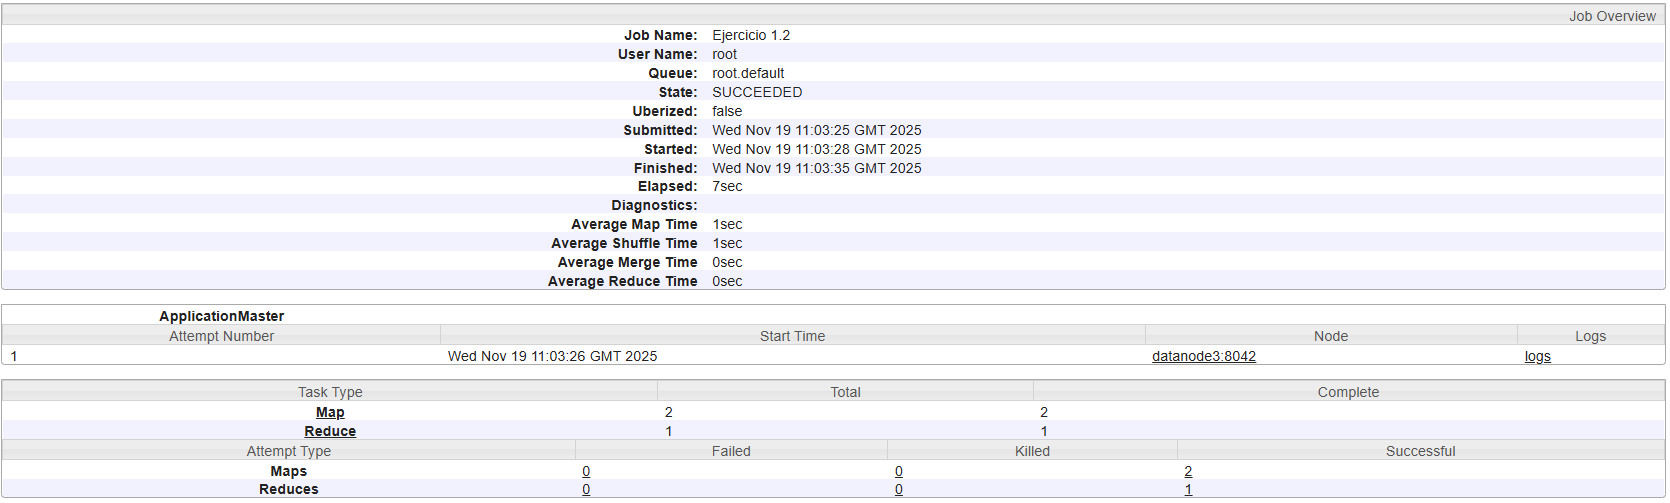

## Ejercicio 1.3
Como en los otros ejercicios, nos aseguraremos de estar en la carpeta correcta y trabajaremos a partir de ahi

In [17]:
# En el caso de que se ejecute varias veces el codigo, asegurarse estar en la carpeta de inicio
import os
os.chdir("/media/notebooks")
!pwd

/media/notebooks


In [18]:
import os
!mkdir -p ejercicio-1.3
os.chdir("ejercicio-1.3")
!pwd

/media/notebooks/ejercicio-1.3


### Ejercicio 1.3 - creación del mapper

En este caso, ya que el ejercicio solamente necesitaremos una modificación en el reducer, usaremos el mismo mapper que en el 1.2

In [19]:
%%writefile mapper-ej1.3.py
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""mapper.py - Ejercicio 1.3"""

import sys

for linea in sys.stdin:
    try:
        linea = linea.strip()
        if not linea:
            continue
        print(f"1\t{linea}")
        
    # En el caso de que haya alguna linea mal formada continuamos
    except Exception as e:
        sys.stderr.write(f"Error procesando línea '{linea}': {e}\n")

Overwriting mapper-ej1.3.py


### Ejercicio 1.3 - creación del reducer

Usaremos el mismo reducer que en el ejercicio 1.2, pero una vez que se procesen las lineas en vez de enviar un solo país, enviaremos la lista completa

In [20]:
%%writefile reducer-ej1.3.py
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""reducer.py - Ejercicio 1.3"""
import sys

conteo_max_actual = 0
paises_con_max = []

# Procesamos línea por línea la entrada
for linea in sys.stdin:
    try:
        clave, valor = linea.strip().split('\t', 1)
        pais, conteo_str = valor.split('\t', 1)
        conteo = int(conteo_str)
        
        if conteo > conteo_max_actual:
            conteo_max_actual = conteo
            paises_con_max = [pais]
        elif conteo == conteo_max_actual:
            paises_con_max.append(pais)

    # En el caso de que haya alguna línea mal formada continuamos
    except ValueError:
        continue
    except Exception as e:
        sys.stderr.write(f"Error procesando línea '{linea}': {e}\n")

# Cambio respecto al ejercicio 1.2, enviamos toda la lista
if conteo_max_actual > 0:
    for pais in sorted(set(paises_con_max)):
        print(f"{pais}\t{conteo_max_actual}")


Overwriting reducer-ej1.3.py


### Ejercicio 1.3 Ejecutar el MapReduce en HDFS

Nos aseguramos de tener los permisos en los archivos

In [21]:

!chmod +x mapper-ej1.3.py
!chmod +x reducer-ej1.3.py

Borramos la salida previa si existe

In [22]:
!hdfs dfs -rm -r /user/ejercicio-1/output_ej1_3

Deleted /user/ejercicio-1/output_ej1_3


Ejecutamos el MapReduce

In [23]:
!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-*.jar \
-D mapred.job.name="Ejercicio 1.3" \
-D mapreduce.job.reduces=1 \
-files $(pwd)/mapper-ej1.3.py,$(pwd)/reducer-ej1.3.py \
-mapper "python3 mapper-ej1.3.py" \
-reducer "python3 reducer-ej1.3.py" \
-input /user/ejercicio-1/output_ej1_1 \
-output /user/ejercicio-1/output_ej1_3

packageJobJar: [/tmp/hadoop-unjar6320521664438517785/] [] /tmp/streamjob3635639742332365331.jar tmpDir=null
2025-11-19 11:13:12,024 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at yarnmanager/172.18.0.3:8032
2025-11-19 11:13:12,100 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at yarnmanager/172.18.0.3:8032
2025-11-19 11:13:12,223 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1763547192244_0009
2025-11-19 11:13:12,493 INFO mapred.FileInputFormat: Total input files to process : 1
2025-11-19 11:13:12,557 INFO mapreduce.JobSubmitter: number of splits:2
2025-11-19 11:13:12,578 INFO Configuration.deprecation: mapred.job.name is deprecated. Instead, use mapreduce.job.name
2025-11-19 11:13:12,644 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1763547192244_0009
2025-11-19 11:13:12,644 INFO mapreduce.JobSubmitter: Executing with tokens: []
2025-11-19

Vamos a visualizar el archivo de salida para ver los resultados

In [24]:
!hdfs dfs -cat /user/ejercicio-1/output_ej1_3/part-00000

Guam	3
Spain	3


Podemos observar que se ha ejecutado correctamente el MapReduce y en la imagen que han hecho falta 2 Mappers y 1 Reduce
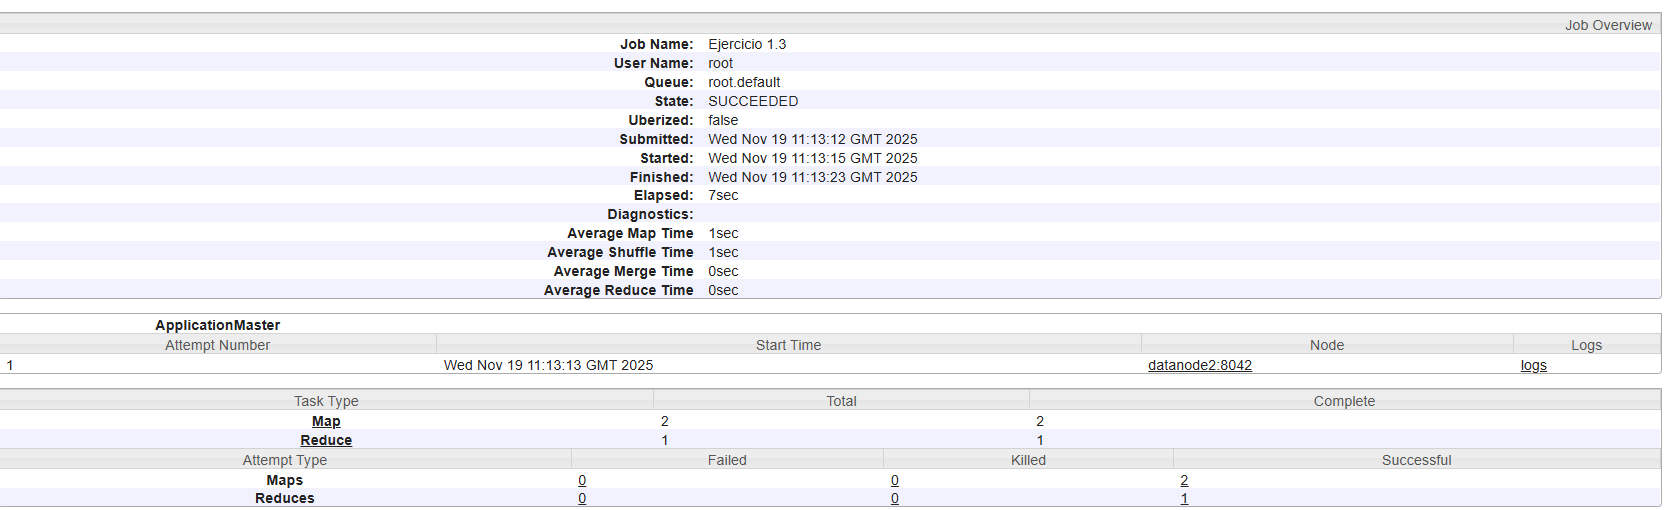